# 4 word2vec 속도 개선

## 4.1 word2vec 개선 1

앞 장의 CBOW모델은 단어 2개를 맥락으로 사용해, 이를 바탕으로 하나의 단어를 추측한다. 이때 입력 측 가중치$W_{in}$와의 행렬 곱으로 은닉층이 계산되고, 다시 출력층 가중치$W_{out}$와의 행렬 곱으로 각 단어의 점수를 구한다. 그리고 이 점수에 소프트맥스 함수를 적용해 각 단어의 출현 확률을 얻고, 이 확률을 정답 레이블과 비교하여 손실을 구한다.

말뭉치가 거대해 지면 다음과 같은 문제가 발생한다.

* 입력층의 원핫 표현과 가중치 행렬$W_{in}$의 곱 계산이 너무 느리다.
* 출력층의 가중치 행렬$W_{out}$과의 곱, 소프트맥스 계산도 느리다.

### 4.1.1 Embedding 계층

* Embedding 계층은 단어 ID에 해당하는 행을 추출하는 계층이다.
* Embedding 계층을 사용하면 단어의 분산 표현을 얻을 수 있다.

### 4.1.2 Embedding 계층 구현

In [1]:
import numpy as np

class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None
    
  def forward(self, idx):
    W = self.params
    self.idx = idx
    out = W[idx]
    return out
  
  def backward(self, dout):
    dW, = self.grads
    dW[...] = 0
    np.add.at(dW, self.idx, dout) # type: ignore
    return None

## 4.2 word2vec 개선 2

네거티브 샘플링(Negative Sampling)이란 기법을 사용하여 속도를 개선한다.

### 4.2.1 은닉층 이후 계산의 문제점

은닉층 이후 계산이 오래 걸리는 곳

* 은닉층의 뉴런과 가중치 행렬$W_{out}$의 곱
* 소프트맥스 함수의 계산

거대한 말뭉치를 다룰 때 이 행렬의 곱을 계산하려면 많은 계산량이 필요하다.

소프트맥스에서도 같은 문제가 발생한다.
$$
Y_{k} = \frac{exp(S_{k})}{\sum_{i=1}^{1,000,000}exp(S_{i})}
$$

k번째 단어의 점수$S_{k}$를 계산하려면 모든 단어의 점수를 계산해야 한다. 이 계산량은 말뭉치의 어휘 수에 비례한다.

### 4.2.2 다중 분류에서 이진 분류로

네거티브 샘플링 기법의 핵심 아이디어는 `이진 분류`이다. 이진 분류는 긍정(positive)과 부정(negative) 두 가지 중 하나를 판단하는 문제이다. 이를 이용하면 다중 분류 문제를 여러 개의 이진 분류 문제로 근사할 수 있다.

### 4.2.3 시그모이드 함수와 교차 엔트로피 오차

이진 분류 문제를 신경망으로 풀려면 점수에 `시그모이드 함수`를 적용해 확률로 변환하고, 손실을 구할 때는 손실 함수로 `교차 엔트로피 오차`를 사용한다.

$$
y = \frac{1}{1+exp(-x)}
$$

그래프는 S자 모양이며, 입력값$(x)$은 0에서 1 사이의 실수로 변환된다. 여기서 시그모이드 함수의 출력$y$는 확률로 해석할 수 있다.

손실은 `교차 엔트로피 오차`를 사용한다.

$$
L = -(tlogy + (1-t)log(1-y))
$$

$y$는 출력이고 $t$는 정답 레이블이다. 이 정답 레이블의 값은 0(부정) 또는 1(긍정)이다.

In [2]:
import numpy as np

class EmbeddingDot:
  """ Embedding 계층과 Dot 계층을 결합한 계층
  Parameters:
    embed: Embedding 계층
    params: 매개변수
    grads: 기울기
    cache: 순전파 시의 계산 결과를 잠시 유지하기 위한 변수
  """
  def __init__(self, W):
    """EmbeddingDot 계층의 초기화

    Args:
      W: 가중치
    
    Returns:
      None
    """
    self.embed = Embedding(W)
    self.params = self.embed.params
    self.grads = self.embed.grads
    self.cache = None
    
    
  def forward(self, h, idx):
    """순전파
    
    Args:
      h: 은닉층 뉴런
      idx: 단어 ID
      
    Returns:
      out: 내적 결과
    """
    target_W = self.embed.forward(idx)
    out = np.sum(target_W * h, axis=1)
    
    self.cache = (h, target_W)
    return out
  
  def backward(self, dout):
    """역전파
    
    Args:
      dout: 상류에서 넘어온 기울기
      
    Returns:
      dh: 하류로 흘려보낼 기울기
    """
    h, target_W = self.cache # type: ignore
    dout = dout.reshape(dout.shape[0], 1)
    
    dtarget_W = dout * h
    self.embed.backward(dtarget_W)
    dh = dout * target_W
    return dh

### 4.2.5 네거티브 샘플링

네거티브 샘플링은 긍정적인 예를 몇 개 선택하고, 그 외에는 모두 부정적인 예로 취급하는 방법이다.

긍정적인 예에 대해서는 시그모이드 함수의 출력을 1에 가깝게 만들고, 부정적인 예에 대해서는 0에 가깝게 만든다.

네거티브 샘플링 기법은 긍정적인 예를 타깃으로 한 경우의 손실과 부정적인 예를 몇 개 샘플링하여, 그 부정정직 예에 대한 손실을 더한 값을 **최종 손실**로 한다.

### 4.2.6 네거티브 샘플링의 샘플링 기법

네거티브 샘플링에서는 부정적인 예를 몇 개 샘플링하는데, 이 샘플링을 어떻게 할지가 중요하다.

말뭉치의 통계 데이터를 기초로 샘플링을 수행한다. 말뭉치에서 자주 등장하는 단어를 많이 추출하고, 드물게 등장하는 단어는 적게 추출한다.

말뭉치에서 단어별 출현 횟수를 바탕으로 확률분포를 구한다음, 그 확률분포에 따라서 샘플링을 수행한다. 확률분포대로 샘플링하므로 말뭉치에에서 자주 등장하는 단어는 선택될 가능성이 높고 드물게 등장하는 단어는 선택될 가능성이 낮다.

In [3]:
# 확률 분포에 따라 샘플링하기

import numpy as np

# 0 ~ 9까지의 숫자 중 하나를 무작위로 샘플링
print(np.random.choice(10))

0


word2vec의 네거티브 샘플링에서는 말뭉치에서 단어의 출현 횟수에 3/4제곱을 한 값을 확률분포로 사용한다.
$$
P'(w_{i}) = \frac{P(w_{i})^{0.75}}{\sum_{j}P(w_{j})^{0.75}} 
$$

여기서$P(w_{i})$는 i번째 단어의 확률을 뜻한다. 식은 단순히 원래 확률분포의 각 요소를 '0.75 제곱'할 뿐이다.

단, 수정 후에도 확률의 총 합은 1이 되어야하므로, 문모로는 '수정 후 확률분포의 총합'이 필요하다.

0.75를 곱하는 이유는 출현 확률이 낮은 단어를 '버리지 않기' 위해서다.

**UnigramSampler Class**

UnigramSampler클래스는 확률 분포를 만들고 다시 0.75를 제곱하는 처리를 담당한다.

In [5]:
from common.np import *
import collections

class UnigramSampler:
  def __init__(self, corpus, power, sample_size):
    self.sample_size = sample_size
    self.vocab_size = None
    self.ward_p = None
    
    counts = collections.Counter()
    for word_id in corpus:
      counts[word_id] += 1
      
    vocab_size = len(counts)
    self.vocab_size = vocab_size
    
    self.word_p = np.zeros(vocab_size)
    for i in range(vocab_size):
      self.word_p[i] = counts[i]
      
    self.word_p = np.power(self.word_p, power)
    self.word_p /= np.sum(self.word_p)
    
  def get_negative_sample(self, target):
    batch_size = target.shape[0]

    if not GPU:
      negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)
      
      for i in range(batch_size):
        p = self.word_p.copy()
        target_idx = target[i]
        p[target_idx] = 0
        p /= p.sum()
        negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        
    else:
      # GPU(cupy）로 계산할 때는 속도를 우선한다.
      # 부정적 예에 타깃이 포함될 수 있다.
      negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size), replace=True, p=self.word_p)
      
    return negative_sample

In [6]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[3 2]
 [1 2]
 [2 3]]


### 4.2.7 네거티브 샘플링 구현

In [20]:
from common.layers import SigmoidWithLoss

class NegativeSamplingLoss:
  def __init__(self, W, corpus, power=0.75, sample_size=5):
    """NegativeSamplingLoss 클래스의 초기화
    
    Args:
      W: 가중치
      corpus: 말뭉치
      power: 0.75
      sample_size: 샘플링 횟수
      
    Returns:
      None
    
    """
    self.sample_size = sample_size
    self.sampler = UnigramSampler(corpus, power, sample_size) # UnigramSampler 클래스의 인스턴스 (부정적 예 샘플링)
    self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] # `sample_size`는 부정적 예의 샘플링 횟수 +1 은 긍정적 예
    self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)] # `sample_size`는 부정적 예의 샘플링 횟수 +1 은 긍정적 예
    
    # 모든 가중치와 기울기를 리스트에 모은다.
    self.params, self.grads = [], []
    # 각 계층의 가중치와 기울기를 params, grads에 추가
    for layer in self.embed_dot_layers:
      self.params += layer.params
      self.grads += layer.grads
      
      
  def forward(self, h, target):
    """순전파
    
    순전파 에서는 `self.sampler`를 이용해 부정적 예를 샘플링하여 `negative_sample`에 저장한다.
    긍정적 예와 부정적 예 각각의 데이터에 대해서 순전파를 수행해 그 손실들을 더한다.
    
    Args:
      h: 은닉층 뉴런
      target: 긍정적 예의 타깃 단어 ID
      
    Returns:
      loss: 손실
    """
    batch_size = target.shape[0]
    negative_sample = self.sampler.get_negative_sample(target)
    
    # 긍정적 예 순전파
    score = self.embed_dot_layers[0].forward(h, target)
    corrent_label = np.ones(batch_size, dtype=int)
    loss = self.loss_layers[0].forward(score, corrent_label)
    
    # 부정적 예 순전파
    negative_label = np.zeros(batch_size, dtype=int)
    for i in range(self.sample_size):
      negative_target = negative_sample[:, i]
      score = self.embed_dot_layers[1 + i].forward(h, negative_target)
      loss += self.loss_layers[1 + i].forward(score, negative_label)
      
    return loss
  
  def backward(self, dout=1):
    """역전파
    
    Args:
      dout: 상류에서 넘어온 기울기
      
    Returns:
      dh: 하류로 흘려보낼 기울기
    """
    dh = 0
    for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
      dscore = l0.backward(dout)
      dh += l1.backward(dscore)
    return dh

## 4.3 개선판 word2vec 학습

PTB 데이터셋을 사용해 개선된 word2vec을 학습시켜보자.

### 4.3.1 CBOW 모델 구현

`SimpleCBOW` 클래스를 개선하여 `CBOW` 클래스를 구현한다.

**개선점**
* Embedding 계층 사용
* 은닉층 이후 계산의 개선 (Negative Sampling Loss 계층 사용)

In [21]:
import numpy as np
from common.layers import Embedding

class CBOW:
  def __init__(self, vocab_size, hidden_size, window_size, corpus):
    """CBOW 모델의 초기화
    
    Args:
      vocab_size: 어휘 수
      hidden_size: 은닉층의 뉴런 수
      window_size: 맥락의 크기
      corpus: 말뭉치 데이터
      
    Returns:
      None
    """
    V, H = vocab_size, hidden_size
    
    # 가중치 초기화
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(V, H).astype('f')
    
    # 계층 생성
    self.in_layers = []
    for _ in range(2 * window_size): # Embedding 계층을 2 * window_size 만큼 생성
      layer = Embedding(W_in)
      self.in_layers.append(layer)
      
    self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
    
    # 모든 가중치와 기울기를 리스트에 모은다.
    layers = self.in_layers + [self.ns_loss]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads
      
    # 인스턴스 변수에 단어의 분산 표현을 저장한다.
    self.word_vecs = W_in
    
  def forward(self, contexts, target):
    h = 0
    for i , layer in enumerate(self.in_layers):
      h += layer.forward(contexts[:, i])
    h *= 1 / len(self.in_layers)
    loss = self.ns_loss.forward(h, target)
    return loss
  
  def backward(self, dout=1):
    dout = self.ns_loss.backward(dout)
    dout *= 1 / len(self.in_layers)
    for layer in self.in_layers:
      layer.backward(dout)
    return None

### 4.3.2 CBOW 모델 학습

말뭉치 안의 어휘 수: 10,000
| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 1[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 1[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 2[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 2[s] | loss 3.93
| epoch 1 |  iter 121 / 9295 | time 3[s] | loss 3.77
| epoch 1 |  iter 141 / 9295 | time 3[s] | loss 3.62
| epoch 1 |  iter 161 / 9295 | time 4[s] | loss 3.48
| epoch 1 |  iter 181 / 9295 | time 4[s] | loss 3.35
| epoch 1 |  iter 201 / 9295 | time 5[s] | loss 3.25
| epoch 1 |  iter 221 / 9295 | time 5[s] | loss 3.16
| epoch 1 |  iter 241 / 9295 | time 6[s] | loss 3.09
| epoch 1 |  iter 261 / 9295 | time 7[s] | loss 3.01
| epoch 1 |  iter 281 / 9295 | time 7[s] | loss 2.97
| epoch 1 |  iter 301 / 9295 | time 8[s] | loss 2.91
| epoch 1 |  iter 321 / 9295 | time 8[s] | loss 2.88
| epoch 1 |  iter 341 / 9295 | time 9[s] | loss 2.83
| epoch 1 |  iter 361 / 9295 | t

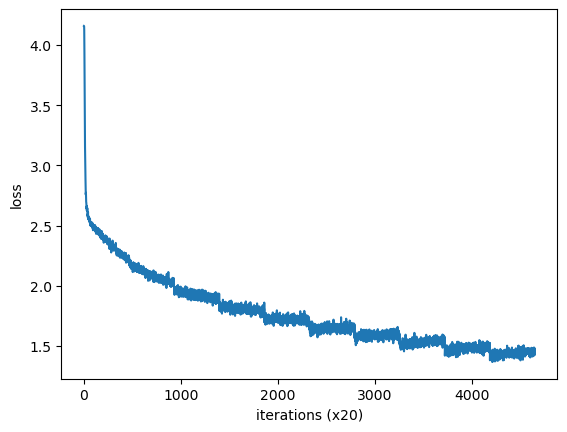

In [22]:
import numpy as np
import pickle
from common import config
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

config.GPU = False

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

print("말뭉치 안의 어휘 수: {:,}".format(vocab_size))

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
  contexts, target = to_gpu(contexts), to_gpu(target)
  
# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중을 위해서 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
  word_vecs = to_cpu(word_vecs)
  
  params = {}
  params['word_vecs'] = word_vecs.astype(np.float16)
  params['word_to_id'] = word_to_id
  params['id_to_word'] = id_to_word
  pkl_file = 'cbow_params.pkl'
  with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)


### 4.3.3 CBOW 모델 평가

In [24]:
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)
  word_vecs = params['word_vecs']
  word_to_id = params['word_to_id']
  id_to_word = params['id_to_word']
  
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625


**King - Man - Woman - Queen Test**

word2vec의 단어의 분산 표현은 단어 사이의 관계를 잘 파악한다. 이를 확인하기 위해 'king - man - woman - queen' 테스트를 수행한다.

In [31]:
from common.util import analogy

analogy('king', 'man', 'woman', word_to_id, id_to_word, word_vecs)
analogy('france', 'paris', 'london', word_to_id, id_to_word, word_vecs)
analogy('france', 'paris', 'rome', word_to_id, id_to_word, word_vecs)


[analogy] king:man = woman:?
 veto: 6.15234375
 ms.: 5.5390625
 successor: 5.39453125
 wife: 5.30859375
 husband: 5.2265625

[analogy] france:paris = london:?
 analyst: 5.8359375
 interview: 5.73828125
 zurich: 5.41796875
 exchange: 5.04296875
 over-the-counter: 4.8125

[analogy] france:paris = rome:?
 brothers: 4.3671875
 street: 4.125
 interview: 4.0
 analyst: 3.98828125
 san: 3.75390625
1 is not found
